In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from sim import sim_and_fit
from betamix import BetaMixture
import numpy as np
from plotting import plot_summary
from betamix import sample_paths



<IPython.core.display.Javascript object>

Check interpolation:

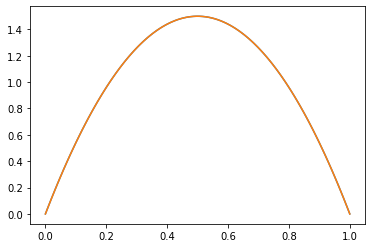

<IPython.core.display.Javascript object>

In [3]:
from jax.scipy.stats import beta
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 200)


def f(x):
    return beta.pdf(x, 2, 2)


BetaMixture.interpolate(f, 2, True).plot()
plt.plot(x, f(x))

## Empirical bayes estimation of prior hyperparameters

In [4]:
model = {"s": [0.02] * 50 + [-0.02] * 50, "h": [0.5] * 100, "f0": 0.1}
res = sim_and_fit(model, seed=1, lam=1e2)

<IPython.core.display.Javascript object>

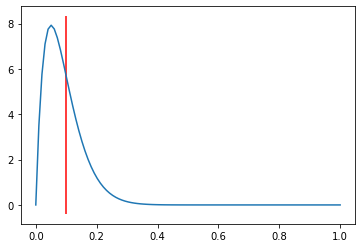

<IPython.core.display.Javascript object>

In [5]:
from estimate import empirical_bayes
import jax

bm = empirical_bayes(res["s_hat"], res["obs"], res["Ne"], 20)
bm.plot()
plt.vlines(model["f0"], *plt.ylim(), color="red")

## Using a different starting frequency

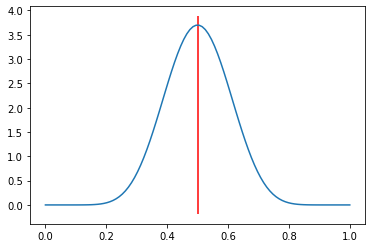

<IPython.core.display.Javascript object>

In [6]:
model["f0"] = 0.5
res = sim_and_fit(model, seed=1, lam=1e2)
bm = empirical_bayes(res["s_hat"], res["obs"], res["Ne"], 20)
bm.plot()
plt.vlines(model["f0"], *plt.ylim(), color="red")

## Effect on inference of $s$

In [7]:
def load_data(file):
    oo = np.loadtxt(file)
    return [oo[:, 1], oo[:, 0]]


pops = ["Britain", "Central", "Iberia", "Italy"][:1]
obs = {x: np.loadtxt("data/" + x + "_LCT.txt").astype(int)[::-1] for x in pops}[
    "Britain"
]
# obs = {k: v[: 1 + np.where(v[:, 0])[0].max()] for k, v in obs.items()}
(times,) = obs[:, 0].nonzero()
sizes = obs[:, 0][times]
T = times.max() + 1
mdl = {"s": [0.01] * T, "h": [0.5] * T, "f0": 0.2}

<IPython.core.display.Javascript object>

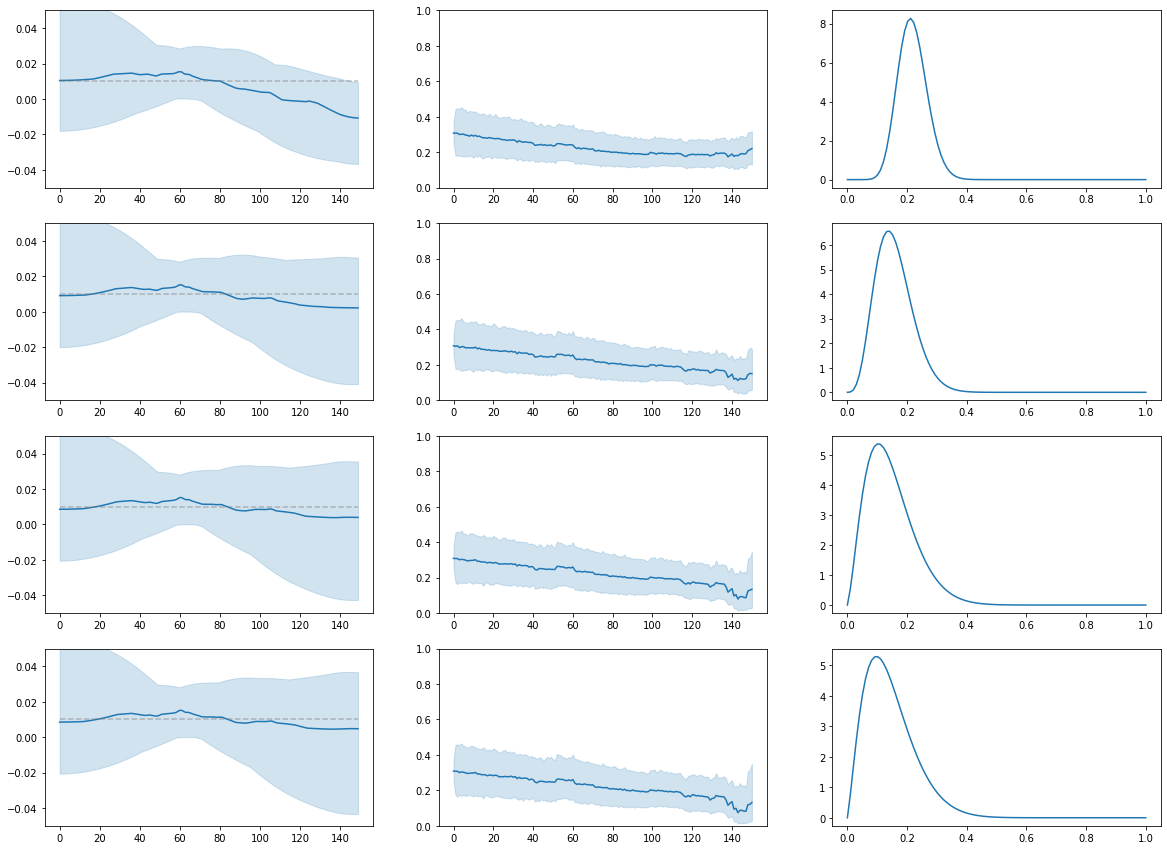

<IPython.core.display.Javascript object>

In [9]:
from concurrent.futures import ProcessPoolExecutor

fig, aaxs = plt.subplots(ncols=3, nrows=4, figsize=(20, 15))
for axs, em_iterations in zip(aaxs, [1, 3, 5, 10]):
    with ProcessPoolExecutor() as p:
        futs = [
            p.submit(
                sim_and_fit,
                mdl,
                seed=i,
                lam=1e4,
                Ne=10000.0,
                k=times,
                n=sizes,
                em_iterations=em_iterations,
            )
            for i in range(20)
        ]
        results = [f.result() for f in futs]
    s_hats = [r["s_hat"] for r in results]
    prior = results[0]["prior"]
    paths, _ = sample_paths(
        s_hats[0], results[0]["Ne"], results[0]["obs"], 1000, prior=prior
    )
    plot_summary(
        axs[0], [tuple(range(len(s_hats[0])))], s_hats, mdl["s"], q=[0.025, 0.5, 0.975]
    )
    plot_summary(axs[1], [tuple(range(len(paths[0])))], paths, q=[0.025, 0.5, 0.975])
    prior.plot(ax=axs[2])
    axs[0].set_ylim(-0.05, 0.05)
    axs[1].set_ylim(0, 1)